In [282]:
import pandas as pd
import numpy as np
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [283]:
df_full = pd.read_csv('./data/final_classification_dataset.csv')
df_full["category"].unique()

array(['Beauty', 'Grocery & Gourmet Food', 'Health & Personal Care',
       'Sports &amp; Outdoors'], dtype=object)

In [284]:
# df_beauty = df_full[df_full.category=='Beauty']
# df_beauty = df_full[df_full.category=='Health & Personal Care']
# df_beauty = df_full[df_full.category=='Grocery & Gourmet Food']
# df_beauty = df_full[df_full.category=='Sports &amp; Outdoors']
df_beauty = df_full[df_full.category!='Sports &amp; Outdoors']
df_beauty.shape

(12058, 404)

In [285]:
df_beauty = df_beauty.drop('category',axis=1)
df_beauty = df_beauty.drop('salesRank',axis=1)
df_beauty = df_beauty.drop('ASIN',axis=1)

In [286]:
#df_beauty.head()

In [287]:
data_vars = df_beauty.columns.values.tolist()
# Target Variable
y = 'class'
# Independent Variables - Feature List
X = [i for i in data_vars if i not in y]

# Data transformation for Analysis
X = np.array(df_beauty[X])
y = np.array(df_beauty[y])
y = y.ravel()

In [288]:
from sklearn.feature_selection import mutual_info_classif
clf = mutual_info_classif(X,y)

In [289]:
feature_cols = []
for col in df_beauty.columns:
    if col != 'class':
        feature_cols.append(col)

# pair the feature names with the coefficients
nameCoefDict = {}
for f,c in zip(feature_cols,list(clf)):
    #print(f," : ",c)
    nameCoefDict[f] = c

#from collections import OrderedDict
d_sorted_by_value = OrderedDict(sorted(nameCoefDict.items(), key=lambda x: x[1]))
good_features = []
for k, v in d_sorted_by_value.items():
    if v != 0.0:
        good_features.append(k)

#for f in good_features:
    #print(f,d_sorted_by_value[f])
#len(good_features)  

# Extract features from Mutual Information and apply those features in Logistic Regression and Random Forest.
X_new = df_beauty[good_features]
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25)

0.587064676617
0.642600438362
[[854 652]
 [593 916]]
True Negative 854
False Positive 652
False Negative 593
True Positive 916


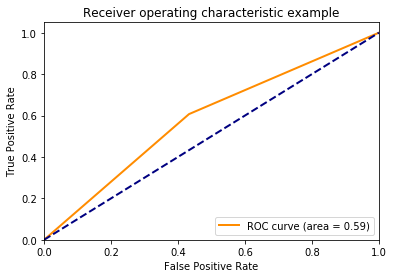

In [290]:
#Logistic Regression with 10 fold cross-validation
logistic = LogisticRegressionCV(cv=10)
logistic = logistic.fit(X_train,y_train)
#print(logistic.coef_)
y_pred = logistic.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(confusion_matrix(y_test,y_pred))
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
print("True Negative", tn)
print("False Positive", fp)
print("False Negative", fn)
print("True Positive", tp)
compute_and_show_ROC( y_test, y_pred )

0.612935323383
0.622145221485
[[879 627]
 [540 969]]
True Negative 879
False Positive 627
False Negative 540
True Positive 969


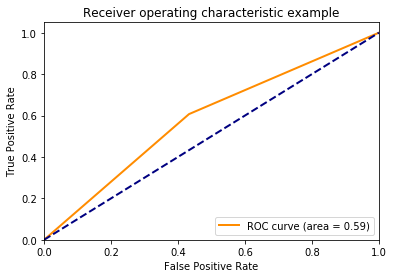

In [291]:
forest = RandomForestClassifier(n_estimators=250,max_features=150)
forest.fit(X_train,y_train)
#print(forest.feature_importances_)
predict = forest.predict(X_test)
print(accuracy_score(y_test,predict))
print(np.sqrt(mean_squared_error(y_test, predict)))
print(confusion_matrix(y_test,predict))
tn, fp, fn, tp = confusion_matrix(y_test,predict).ravel()
print("True Negative", tn)
print("False Positive", fp)
print("False Negative", fn)
print("True Positive", tp)
compute_and_show_ROC( y_test, y_pred )

In [292]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(),
    n_estimators=250,
    learning_rate=1)

bdt_real.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=250, random_state=None)

In [293]:
# boost is the secret of my energy -  step by step
sachin = []
for real_test_predict in bdt_real.staged_predict(X_test) :
    sachin.append( accuracy_score(real_test_predict, y_test) ) 

# len( sachin ) #600

print( np.mean( sachin ) )


0.543615257048


0.537313432836
[[879 627]
 [540 969]]


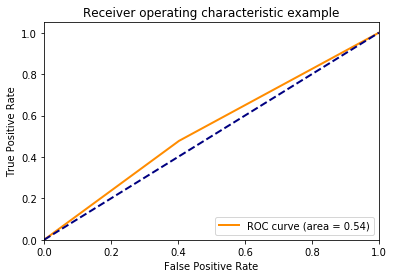

In [294]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit( X_train, y_train )
y_pred = clf.predict( X_test )
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,predict))
compute_and_show_ROC( y_test, y_pred )

In [295]:
def compute_and_show_ROC( y_test, y_pred) :
    # Compute ROC curve and ROC area for each class
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    n_classes = 2 #y.shape[1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Compute micro-average ROC curve and ROC area
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()